In [2]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks, butter, filtfilt
import matplotlib.pyplot as plt

In [11]:
try:
    # Load your CSV file here
    df = pd.read_csv('nathan_2025-1.csv', delimiter=';')
except FileNotFoundError:
    print("csv not found. Generating a sample dataset for demonstration.")
    # Generate a sample PPG-like signal
    fs_gen = 100  # Sampling frequency in Hz
    duration = 20  # seconds
    time = np.arange(0, duration, 1/fs_gen)
    heart_rate = 75  # beats per minute
    beat_period = 60 / heart_rate

    # Create a periodic signal
    signal = np.sin(2 * np.pi * (1/beat_period) * time) ** 4
    # Add some noise
    noise = 0.1 * np.random.randn(len(time))
    signal += noise
    # Add a baseline drift
    signal += 0.2 * np.sin(2 * np.pi * 0.1 * time)

    # Create DataFrame
    timestamps_ms = (time * 1000).astype(int)
    df = pd.DataFrame({'timestamp(ms)': timestamps_ms, 'signal': signal})

# Drop columns that are completely null (all values are NaN)
df = df.dropna(axis=1, how='all')

# Rename columns for easier access if they have special characters or spaces
df.columns = ['timestamp_ms', 'signal']

print("Data loaded successfully. Here are the first 5 rows:")
print(df.head())

Data loaded successfully. Here are the first 5 rows:
   timestamp_ms  signal
0  1.751249e+09  122123
1  1.751249e+09  122136
2  1.751249e+09  122220
3  1.751249e+09  122317
4  1.751249e+09  122358


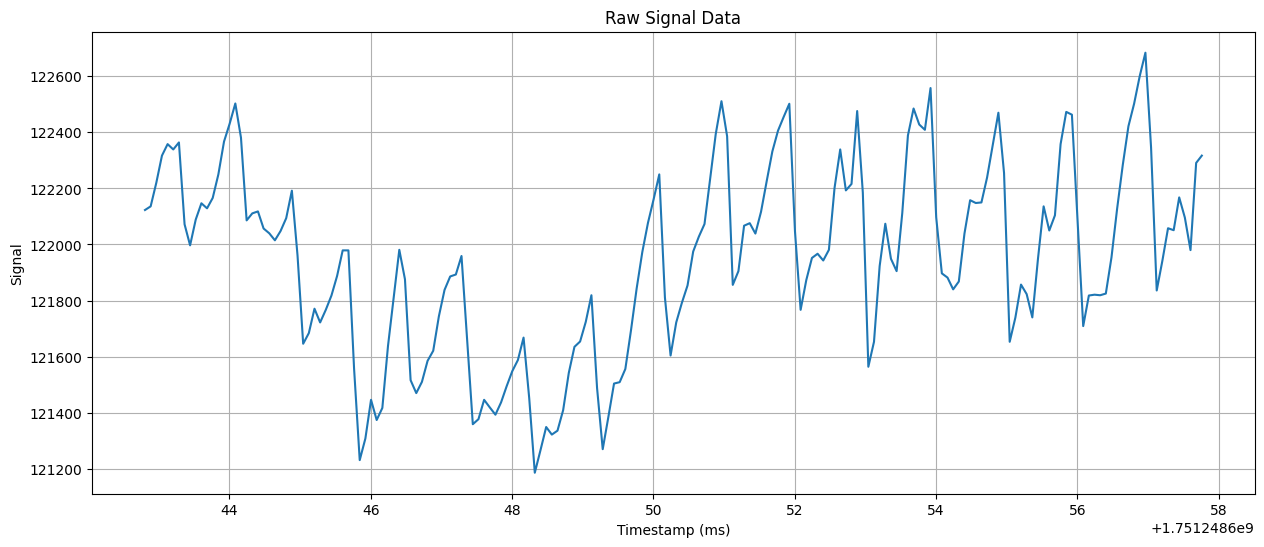

In [12]:
plt.figure(figsize=(15, 6))
plt.plot(df['timestamp_ms'], df['signal'])
plt.xlabel('Timestamp (ms)')
plt.ylabel('Signal')
plt.title('Raw Signal Data')
plt.grid(True)
plt.show()

In [13]:
# --- Signal Filtering ---
# First, determine the sampling rate (Fs) from the timestamps
# We calculate the median difference between timestamps and convert it to Hz
sampling_interval_ms = np.median(np.diff(df['timestamp_ms']))
fs = 1000 / sampling_interval_ms  # Sampling frequency in Hz
print(f"\nDetected Sampling Frequency: {fs:.2f} Hz")

# Design a bandpass filter (e.g., from 0.5 Hz to 8 Hz, typical for heart rate)
low_cut = 0.5
high_cut = 8.0
nyquist = 0.5 * fs
low = low_cut / nyquist
high = high_cut / nyquist
b, a = butter(2, [low, high], btype='band')

# Apply the filter to the signal
filtered_signal = filtfilt(b, a, df['signal'])


Detected Sampling Frequency: 12500.01 Hz


In [14]:
min_peak_distance = fs * 0.3 # Minimum distance corresponding to ~200 bpm

peaks, properties = find_peaks(
    filtered_signal,
    height=np.max(filtered_signal) * 0.5, # Peaks must be at least 50% of the max height
    distance=min_peak_distance
)

print(f"Found {len(peaks)} peaks in the signal.")

Found 0 peaks in the signal.


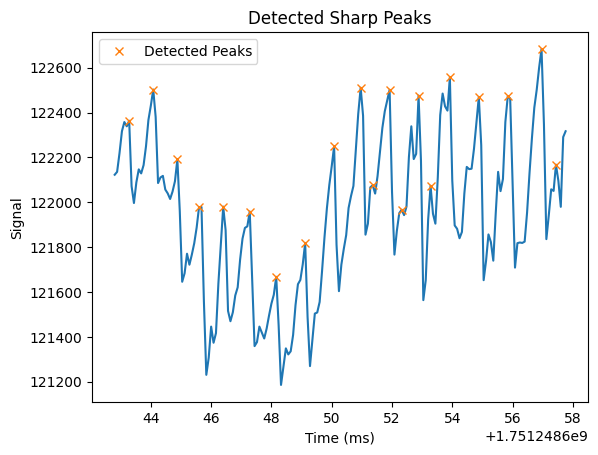

Found 20 peaks in the signal.


In [18]:
# Detect peaks
peaks, properties = find_peaks(
    df['signal'],
    prominence=10,       # filters out low peaks
    width=(1, 8),        # finds **narrow** peaks
    distance=5           # minimum distance between peaks
)

# Plot
plt.plot(df['timestamp_ms'], df['signal'])
plt.plot(df['timestamp_ms'][peaks], df['signal'][peaks], "x", label="Detected Peaks")
plt.title("Detected Sharp Peaks")
plt.xlabel("Time (ms)")
plt.ylabel("Signal")
plt.legend()
plt.show()

print(f"Found {len(peaks)} peaks in the signal.")

In [19]:
peak_timestamps = df['timestamp_ms'].iloc[peaks].values
peak_signal_values = df['signal'].iloc[peaks].values

peak_data = pd.DataFrame({
    'peak_timestamp_ms': peak_timestamps,
    'peak_signal_value': peak_signal_values
})

print("\nPeak Data:")
print(peak_data)


Peak Data:
    peak_timestamp_ms  peak_signal_value
0        1.751249e+09             122364
1        1.751249e+09             122503
2        1.751249e+09             122192
3        1.751249e+09             121979
4        1.751249e+09             121981
5        1.751249e+09             121959
6        1.751249e+09             121668
7        1.751249e+09             121819
8        1.751249e+09             122250
9        1.751249e+09             122511
10       1.751249e+09             122076
11       1.751249e+09             122502
12       1.751249e+09             121967
13       1.751249e+09             122476
14       1.751249e+09             122074
15       1.751249e+09             122558
16       1.751249e+09             122470
17       1.751249e+09             122473
18       1.751249e+09             122684
19       1.751249e+09             122168


In [20]:
# Calculate the difference between consecutive timestamps
pp_intervals_ms = np.diff(peak_timestamps)

print("\n--- Peak-to-Peak Intervals ---")
for i, interval in enumerate(pp_intervals_ms):
    print(f"Interval {i+1}: {interval} ms")

# You can also create a DataFrame for the results
results_df = pd.DataFrame({
    'Interval Start Time (ms)': peak_timestamps[:-1],
    'Interval End Time (ms)': peak_timestamps[1:],
    'Peak-to-Peak Interval (ms)': pp_intervals_ms
})


--- Peak-to-Peak Intervals ---
Interval 1: 0.7980000972747803 ms
Interval 2: 0.7999999523162842 ms
Interval 3: 0.7190001010894775 ms
Interval 4: 0.8009998798370361 ms
Interval 5: 0.880000114440918 ms
Interval 6: 0.878000020980835 ms
Interval 7: 0.9599997997283936 ms
Interval 8: 0.9600000381469727 ms
Interval 9: 0.880000114440918 ms
Interval 10: 0.39999985694885254 ms
Interval 11: 0.5600001811981201 ms
Interval 12: 0.39999985694885254 ms
Interval 13: 0.559999942779541 ms
Interval 14: 0.39800000190734863 ms
Interval 15: 0.6400001049041748 ms
Interval 16: 0.9600000381469727 ms
Interval 17: 0.9600000381469727 ms
Interval 18: 1.119999885559082 ms
Interval 19: 0.4779999256134033 ms


In [21]:
print("\n--- Results in a DataFrame ---")
print(results_df)

### 7. Calculate Heart Rate Variability (HRV) Metrics ###
if len(pp_intervals_ms) > 1:
    # --- Calculate SDNN (Standard Deviation of NN intervals) ---
    sdnn = np.std(pp_intervals_ms)
    print(f"\n--- HRV Metrics ---")
    print(f"SDNN: {sdnn:.2f} ms")

    # --- Calculate RMSSD (Root Mean Square of Successive Differences) ---
    successive_diffs = np.diff(pp_intervals_ms)
    rmssd = np.sqrt(np.mean(successive_diffs**2))
    print(f"RMSSD: {rmssd:.2f} ms")

else:
    print("\nNot enough peak-to-peak intervals to calculate HRV metrics.")


--- Results in a DataFrame ---
    Interval Start Time (ms)  Interval End Time (ms)  \
0               1.751249e+09            1.751249e+09   
1               1.751249e+09            1.751249e+09   
2               1.751249e+09            1.751249e+09   
3               1.751249e+09            1.751249e+09   
4               1.751249e+09            1.751249e+09   
5               1.751249e+09            1.751249e+09   
6               1.751249e+09            1.751249e+09   
7               1.751249e+09            1.751249e+09   
8               1.751249e+09            1.751249e+09   
9               1.751249e+09            1.751249e+09   
10              1.751249e+09            1.751249e+09   
11              1.751249e+09            1.751249e+09   
12              1.751249e+09            1.751249e+09   
13              1.751249e+09            1.751249e+09   
14              1.751249e+09            1.751249e+09   
15              1.751249e+09            1.751249e+09   
16              

In [1]:
!pip install muselsl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 1.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 3.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.4/927.4 kB 10.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.5/320.5 kB 14.1 MB/s eta 0:00:00


In [2]:
muselsl list

SyntaxError: invalid syntax (2479556246.py, line 1)